Lens Modeling for DESIJ1537+1443

Author(s): Md. Mehedi Hasan, Anowar J. Shajib

In [20]:
import h5py
import joblib
import matplotlib.pyplot as plt
import numpy as np
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

%matplotlib inline

In [21]:
with h5py.File("DESIJ1537+1443_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]

image_data = kwargs_data["image_data"]


with h5py.File("psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]

kwargs_psf["psf_type"] = "PIXEL"

C:\Users\HTCM\AppData\Local\Temp\ipykernel_1912\2739470995.py:1: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix");


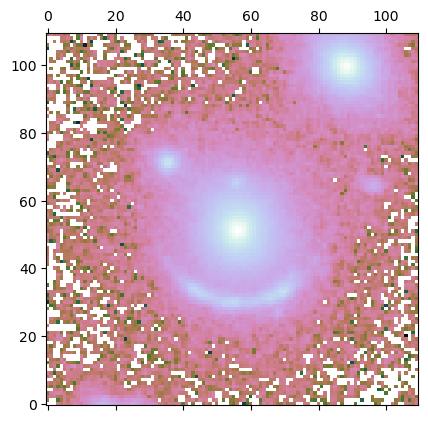

In [22]:
plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix");

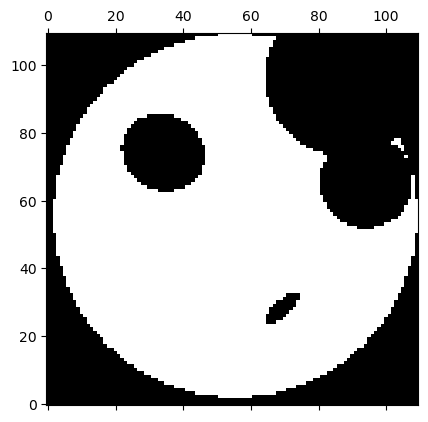

C:\Users\HTCM\AppData\Local\Temp\ipykernel_1912\2961394688.py:85: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
C:\Users\HTCM\AppData\Local\Temp\ipykernel_1912\2961394688.py:85: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")


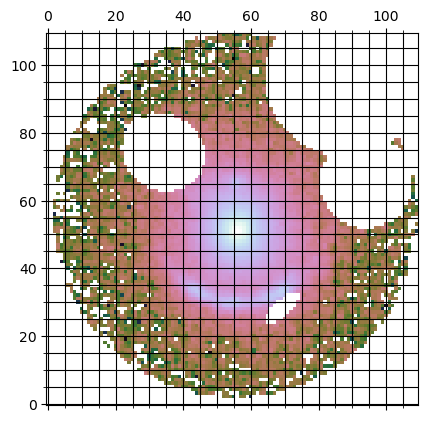

In [23]:
ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)


r = 4.3  # In Arcseconds
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra + 0,
    lens_center_dec + 0,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)


mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.6,
    lens_center_dec + 3.3,
    1.9,
    1.9,
    6,
)


mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 3.1,
    lens_center_dec + 0.8,
    1.1,
    1.1,
    6,
)


mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1.7,
    lens_center_dec + 1.5,
    0.9,
    1,
    2,
)

mask_ext_4 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 1.1,
    lens_center_dec - 2.2,
    0.2,
    0.5,
    4,
)


mask = (
    (1 - mask_outer)
    * (1 - mask_ext_1)
    * (1 - mask_ext_2)
    * (1 - mask_ext_3)
    * (1 - mask_ext_4)
)

mask[mask >= 1] = 1
mask[mask < 0] = 0

mask = mask.reshape(num_pix, num_pix)

plt.matshow(mask, origin="lower", cmap="cubehelix")
plt.show()

# Masking Image Data
masked_image_data = np.multiply(image_data, mask)
plt.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
plt.grid(which="both", color="black")
plt.minorticks_on()
plt.grid(which="minor", color="black")
plt.show()

In [24]:
lens_model_list = ["EPL", "SHEAR"]

source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]

lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

In [33]:
# Lens Galaxy's Mass Model

fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})
fixed_lens.append({"ra_0": 0, "dec_0": 0})

kwargs_lens_init.append(
    {
        "theta_E": 1.5,  # 1.0
        "gamma": 1.7,  # 2.0
        "e1": -0.06,  # 0.0
        "e2": 0.03,  # 0.0
        "center_x": -0.06,
        "center_y": -0.34,
    }
)


kwargs_lens_init.append({"gamma1": 0.03, "gamma2": 0.01})


kwargs_lens_sigma.append(
    {
        "theta_E": 0.2,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)

kwargs_lens_sigma.append({"gamma1": 0.1, "gamma2": 0.1})

kwargs_lower_lens.append(
    {
        "theta_E": 0.01,
        "gamma": 1.0,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)

kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3})

kwargs_upper_lens.append(
    {
        "theta_E": 10.0,
        "gamma": 3.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)

kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3})


lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]


# Lens Galaxy's Light Model
# 1st Sersic

fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({"n_sersic": 4.0})


kwargs_lens_light_init.append(
    {
        "R_sersic": 0.6,
        "n_sersic": 2,
        "e1": -0.06,
        "e2": 0.03,
        "center_x": -0.06,
        "center_y": -0.03,
        "amp": 16,
    }
)

kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)


kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -2,
        "center_y": -2,
        "amp": 0,
    }
)

kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 1.0,
        "n_sersic": 5.0,
        "center_x": 2,
        "center_y": 2,
        "amp": 100,
    }
)

# 2nd Sersic

fixed_lens_light.append({"n_sersic": 4.0})


kwargs_lens_light_init.append(
    {
        "R_sersic": 0.6,
        "n_sersic": 2,
        "e1": -0.06,
        "e2": 0.03,
        "center_x": -0.06,
        "center_y": -0.03,
        "amp": 16,
    }
)

kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)


kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -2,
        "center_y": -2,
        "amp": 0,
    }
)

kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 1.0,
        "n_sersic": 5.0,
        "center_x": 2,
        "center_y": 2,
        "amp": 100,
    }
)


joint_lens_with_light = [[0, 0, ["center_x", "center_y", "e1", "e2"]]]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]


# Source Galaxy's Light Model

fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


fixed_source.append({"n_sersic": 1.0})
fixed_source.append({"n_max": 6})

kwargs_source_init.append(
    {
        "R_sersic": 0.2,
        "n_sersic": 1,
        "e1": 0.2,
        "e2": 0.15,
        "center_x": -0.08,
        "center_y": -0.6,
        "amp": 16,
    }
)

kwargs_source_init.append({"beta": 0.04, "center_x": 0, "center_y": 0})


kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.1,
        "e1": 0.08,
        "e2": 0.07,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)

kwargs_source_sigma.append({"beta": 0.02, "center_x": 0.2, "center_y": 0.2})


kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -2,
        "center_y": -2,
        "amp": 0,
    }
)

kwargs_lower_source.append({"beta": 0.04, "center_x": -2, "center_y": -2})

kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 0.15,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

kwargs_upper_source.append({"beta": 0.1, "center_x": 2, "center_y": 2})


joint_source_with_source = [[0, 1, ["center_x", "center_y"]]]

source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]


# Combining Everything in `kwargs_params` Dictionary
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}


kwargs_constraints = {
    "joint_lens_with_light": joint_lens_with_light,
    "joint_source_with_source": joint_source_with_source,
}

In [34]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask]}


kwargs_numerics = {"supersampling_factor": 1, "supersampling_convolution": False}

In [35]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}


multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]


kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band",
}

In [36]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}


multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]


kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band",
}

In [37]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)


fitting_kwargs_list = [
    ["PSO", {"sigma_scale": 1.0, "n_particles": 100, "n_iterations": 100}],
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-0.9280737030193318 reduced X^2 of best position
-3321.5757831061883 log likelihood
7158 effective number of data points
[{'theta_E': 1.578768843429009, 'gamma': 1.8591083678431473, 'e1': -0.27715791912781684, 'e2': 0.07145838334426512, 'center_x': -0.036971660451962235, 'center_y': -0.1005653276987242}, {'gamma1': -0.07091229565761052, 'gamma2': 0.032929825964720986, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.1499990166241481, 'n_sersic': 1.0, 'e1': 0.3553142000786378, 'e2': 0.05697788120457542, 'center_x': -0.10457326739110724, 'center_y': -0.499888759814219}, {'amp': 1, 'n_max': 6, 'beta': 0.041642183773076664, 'center_x': -0.10457326739110724, 'center_y': -0.499888759814219}] source result
[{'amp': 1, 'R_sersic': 0.6676812207380224, 'n_sersic': 4.0, 'e1': -0.27715791912781684, 'e2': 0.07145838334426512, 'center_x': -0.036971660451962235, 'center_y': -0.1005653276987242}, {'amp':

In [38]:
kwargs_result = fitting_seq.best_fit(bijective=False)
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed()

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "./DESIJ1537+1443_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

-0.9215080546833647 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9215080546833654


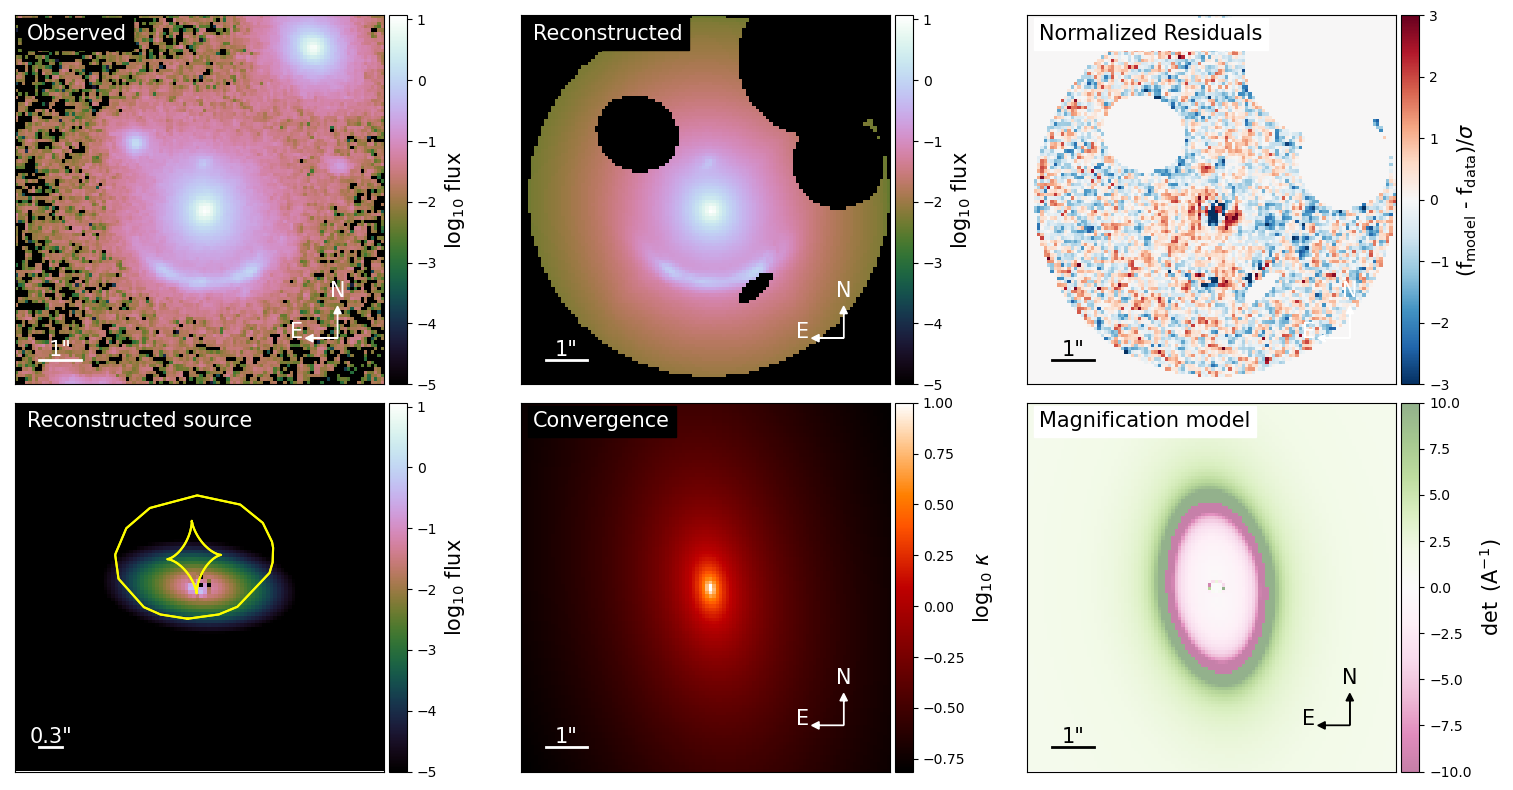

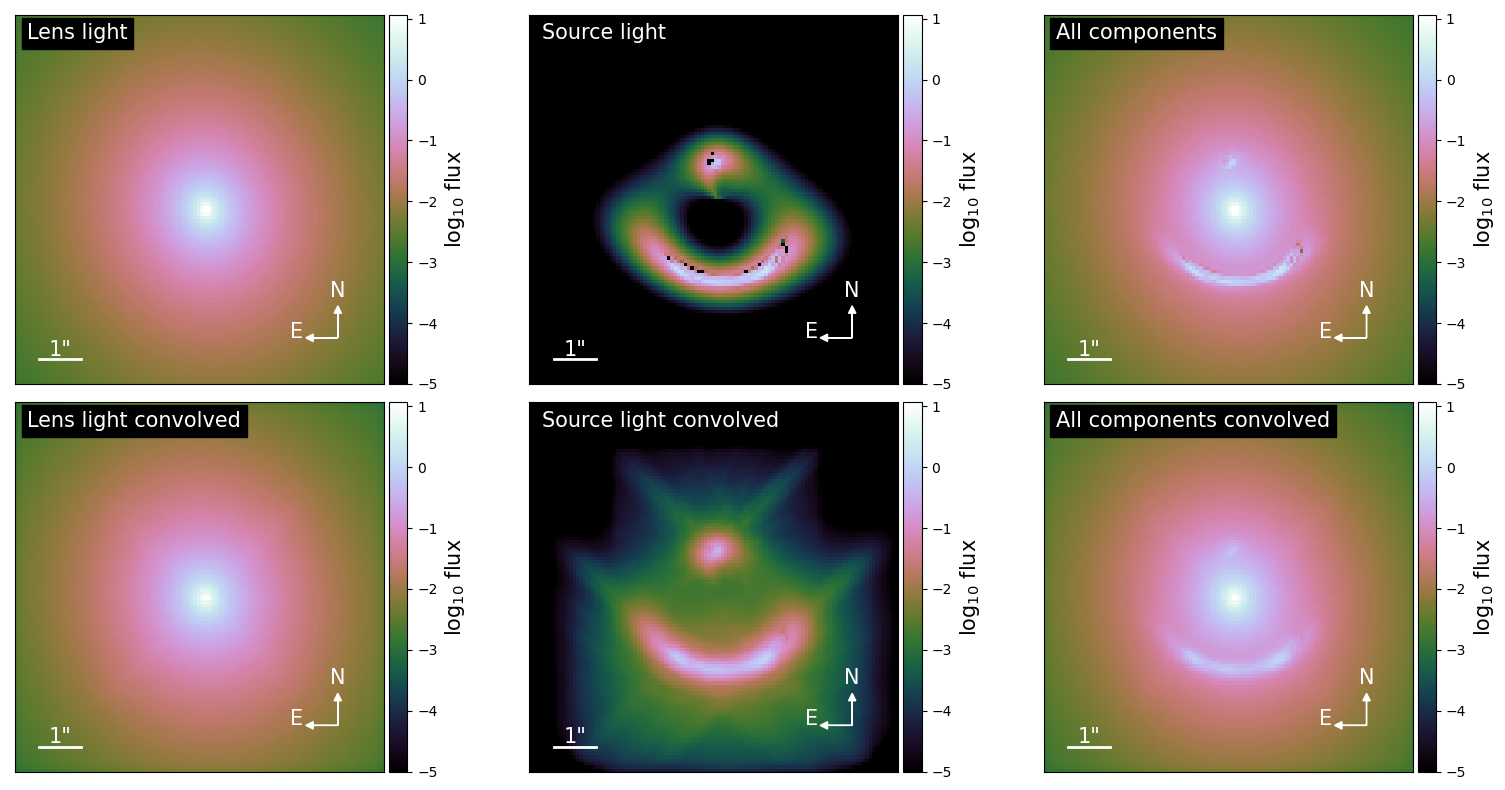

{'kwargs_lens': [{'theta_E': 1.578768843429009, 'gamma': 1.8591083678431473, 'e1': -0.27715791912781684, 'e2': 0.07145838334426512, 'center_x': -0.036971660451962235, 'center_y': -0.1005653276987242}, {'gamma1': -0.07091229565761052, 'gamma2': 0.032929825964720986, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 21.01987141272657, 'R_sersic': 0.1499990166241481, 'n_sersic': 1.0, 'e1': 0.3553142000786378, 'e2': 0.05697788120457542, 'center_x': -0.10457326739110724, 'center_y': -0.499888759814219}, {'amp': array([ 179.55571289,  128.90380728, -229.69730535,   23.87902946,
         36.97314736,  128.37864776,  111.64063692,   21.17457704,
        -74.61295201,  -28.81911675,  173.19919703,  -33.09219815,
        -36.60142828,   54.01424292,    4.29669254,  160.69025159,
        -76.4269326 ,    7.19409132,  -36.97551389,    2.78915783,
        -13.62989654,  -41.95264789,  -32.37913494,  -37.3824888 ,
        -42.23401191,   16.42484827,   -1.65131783,  -33.38836519]), 'n_max': 6, 'bet

In [39]:
modelPlot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
    linear_solver=kwargs_constraints.get("linear_solver", True),
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0, 0])

modelPlot.model_plot(ax=axes[0, 1])

modelPlot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")

modelPlot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.05, numPix=100, with_caustics=True, scale_size=0.3
)

modelPlot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")

modelPlot.magnification_plot(ax=axes[1, 2], cmap="PiYG")

f.tight_layout()

f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)

plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)

modelPlot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)

modelPlot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)

modelPlot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)

modelPlot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)

modelPlot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)

f.tight_layout()

f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)

plt.show()
print(kwargs_result)